# Import Libraries

In [9]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Progress bar for loops
from tqdm import tqdm

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px


# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


# Deep learning with TensorFlow and Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM
from tensorflow.keras.optimizers import Adam

# PyTorch for deep learning
import torch.nn as nn
import torch.optim as optim

# Network analysis and graph-related operations
import networkx as nx

# Date and time operations
from datetime import datetime

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Read the Data

## Flight Data

In [13]:
# Specify the time frame to be used for analysis
years = ['2023']
months = range(7, 13)

# Calculate total iterations
total_iterations = len(years) * len(months)

df = pd.DataFrame()

with tqdm(total=total_iterations, desc="Fetching Data", unit="file") as pbar:
    for year in years:
        for i in months:
            file_path = f'Desktop/BTS Dataset/On time performance/{year}/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_{year}_{i}.csv'
            tmp = pd.read_csv(file_path, low_memory=False)
            df = pd.concat([df, tmp], axis=0)
            pbar.update(1)

print('All data fetching complete.')

print (len(df))

Fetching Data: 100%|████████████████████████████| 6/6 [00:33<00:00,  5.54s/file]

All data fetching complete.
3507330


### Visualise few rows with selected columns

In [18]:
data_df = df[['Origin','Dest','IATA_CODE_Reporting_Airline','OriginCityName','DestCityName','FlightDate','Tail_Number','DOT_ID_Reporting_Airline','Flight_Number_Reporting_Airline','OriginAirportID','DestAirportID','CRSDepTime','DepTime','DepDelay','CRSArrTime','ArrTime','ArrDelay','CRSElapsedTime', 'ActualElapsedTime','Cancelled','CancellationCode','Diverted','Distance','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']]

data_df.head()

,Origin,Dest,IATA_CODE_Reporting_Airline,OriginCityName,DestCityName,FlightDate,Tail_Number,DOT_ID_Reporting_Airline,Flight_Number_Reporting_Airline,OriginAirportID,...,ActualElapsedTime,Cancelled,CancellationCode,Diverted,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,DTW,DSM,9E,"Detroit, MI","Des Moines, IA",2023-07-02,N307PQ,20363,4900,11433,...,93.0,0.0,NaN,0.0,533.0,NaN,NaN,NaN,NaN,NaN
1,DTW,DSM,9E,"Detroit, MI","Des Moines, IA",2023-07-05,N232PQ,20363,4900,11433,...,95.0,0.0,NaN,0.0,533.0,NaN,NaN,NaN,NaN,NaN
2,DTW,DSM,9E,"Detroit, MI","Des Moines, IA",2023-07-09,N480PX,20363,4900,11433,...,96.0,0.0,NaN,0.0,533.0,NaN,NaN,NaN,NaN,NaN
3,RIC,MSP,9E,"Richmond, VA","Minneapolis, MN",2023-07-10,N304PQ,20363,4900,14524,...,156.0,0.0,NaN,0.0,970.0,NaN,NaN,NaN,NaN,NaN
4,RIC,MSP,9E,"Richmond, VA","Minneapolis, MN",2023-07-11,N184GJ,20363,4900,14524,...,161.0,0.0,NaN,0.0,970.0,NaN,NaN,NaN,NaN,NaN


## Airport Location Data

In [31]:
file_path = f'Desktop/BTS Dataset/airports.csv'
airports_df = pd.read_csv(file_path, low_memory=False, header=None, names = ['Airport ID','Name','City','Country','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST','Tz','Type','Source'])

airports_df.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


# Exploratory Data Analysis

## Merge Flight Data and Airport Location data

In [58]:
origins_airports_df = airports_df.copy()[['IATA','Latitude','Longitude']].rename(columns = {'Latitude':'Origin_Latitude','Longitude':'Origin_Longitude'})
dest_airports_df = airports_df.copy()[['IATA','Latitude','Longitude']].rename(columns = {'Latitude':'Dest_Latitude','Longitude':'Dest_Longitude'})

data = pd.merge(data_df, origins_airports_df, how = 'inner', left_on = ['Origin'], right_on = ['IATA']).drop(columns = ['IATA'])
data = pd.merge(data, dest_airports_df, how = 'inner', left_on = ['Dest'], right_on = ['IATA']).drop(columns = ['IATA'])

## Summary Statistics

In [37]:
data.nunique()

Origin                              343
Dest                                343
IATA_CODE_Reporting_Airline          15
OriginCityName                      337
DestCityName                        337
FlightDate                          184
Tail_Number                        5811
DOT_ID_Reporting_Airline             15
Flight_Number_Reporting_Airline    6155
OriginAirportID                     343
DestAirportID                       343
CRSDepTime                         1325
DepTime                            1440
DepDelay                           1653
CRSArrTime                         1424
ArrTime                            1440
ArrDelay                           1686
CRSElapsedTime                      537
ActualElapsedTime                   694
Cancelled                             2
CancellationCode                      4
Diverted                              2
Distance                           1553
CarrierDelay                       1450
WeatherDelay                        843


## Filling missing data for Delay Columns

In [71]:
def hhmm_to_minutes(hhmm):
    hh = hhmm // 100
    mm = hhmm % 100
    return hh * 60 + mm
    
# For departure columns
# Convert DepTime and CRSDepTime to minutes
data['DepTime_in_minutes'] = data['DepTime'].apply(lambda data: hhmm_to_minutes(data) if pd.notna(data) else np.nan)
data['CRSDepTime_in_minutes'] = data['CRSDepTime'].apply(lambda data: hhmm_to_minutes(data) if pd.notna(data) else np.nan)
data['DepDelay'] = data['DepDelay'].fillna(data['DepTime_in_minutes'] - data['CRSDepTime_in_minutes'])
data['DepTime_in_minutes'] = data['DepTime_in_minutes'].fillna(data['CRSDepTime_in_minutes'] + data['DepDelay'])
data['CRSDepTime_in_minutes'] = data['CRSDepTime_in_minutes'].fillna(data['DepTime_in_minutes'] - data['DepDelay'])
# Convert back from minutes to hhmm format for DepTime and CRSDepTime
data['DepTime'] = data['DepTime_in_minutes'].apply(lambda data: int(data // 60) * 100 + int(data % 60) if pd.notna(data) else np.nan)
data['CRSDepTime'] = data['CRSDepTime_in_minutes'].apply(lambda data: int(data // 60) * 100 + int(data % 60) if pd.notna(data) else np.nan)
data = data.drop(columns=['DepTime_in_minutes', 'CRSDepTime_in_minutes'])


print('Departure columns nulls filled.')

# For arrival columns
# Convert ArrTime and CRSArrTime to minutes
data['ArrTime_in_minutes'] = data['ArrTime'].apply(lambda data: hhmm_to_minutes(data) if pd.notna(data) else np.nan)
data['CRSArrTime_in_minutes'] = data['CRSArrTime'].apply(lambda data: hhmm_to_minutes(data) if pd.notna(data) else np.nan)
data['ArrDelay'] = data['ArrDelay'].fillna(data['ArrTime_in_minutes'] - data['CRSArrTime_in_minutes'])
data['ArrTime_in_minutes'] = data['ArrTime_in_minutes'].fillna(data['CRSArrTime_in_minutes'] + data['ArrDelay'])
data['CRSArrTime_in_minutes'] = data['CRSArrTime_in_minutes'].fillna(data['ArrTime_in_minutes'] - data['ArrDelay'])
# Convert back from minutes to hhmm format for ArrTime and CRSArrTime
data['ArrTime'] = data['ArrTime_in_minutes'].apply(lambda data: int(data // 60) * 100 + int(data % 60) if pd.notna(data) else np.nan)
data['CRSArrTime'] = data['CRSArrTime_in_minutes'].apply(lambda data: int(data // 60) * 100 + int(data % 60) if pd.notna(data) else np.nan)
data = data.drop(columns=['ArrTime_in_minutes', 'CRSArrTime_in_minutes'])

print('Arrivals columns nulls filled.')

Departure columns nulls filled.
Arrivals columns nulls filled.


## Drop data with missing actual information for delays

In [97]:
#Imputing DelayReasons for missing ones
delayed_data = data[data['ArrDelay']>0].copy().reset_index()
columns_to_impute = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

# Features to use for imputation
imputation_features = ['DepDelay', 'ArrDelay'] + columns_to_impute

# Create the IterativeImputer
imputer = IterativeImputer(
    # estimator=LinearRegression(),
    max_iter=10,
    random_state=42
)

# Fit and transform the data
imputed_data = imputer.fit_transform(delayed_data[imputation_features])
imputed_df = pd.DataFrame(imputed_data, columns=imputation_features)

for column in columns_to_impute:
    delayed_data[column] = np.where(imputed_df[column] < 0, 0, imputed_df[column])

non_delayed_data = data[data['ArrDelay']<=0].copy()
non_delayed_data[columns_to_impute] = 0

data_cleaned = pd.concat([delayed_data, non_delayed_data]).reset_index()

print ('Remaining Data (After dropping rows without actual information of arrivals) %:', (round(((len(data_cleaned)*100)/len(data)),2)))
print ('Data Length:', len(data_cleaned))

Remaining Data (After dropping rows without actual information of arrivals) %: 98.95
Data Length: 3468783


## Extract Target Column

In [100]:
data_cleaned['CLADelay'] = np.round(data_cleaned['LateAircraftDelay']) + np.round(data_cleaned['CarrierDelay'])

## Extract Basic Temporal Features

In [78]:
data_cleaned['FlightDate'] = pd.to_datetime(data_cleaned['FlightDate'])
data_cleaned['Year'] = data_cleaned['FlightDate'].dt.year
data_cleaned['Month'] = data_cleaned['FlightDate'].dt.month
data_cleaned['Day'] = data_cleaned['FlightDate'].dt.day
data_cleaned['DayOfWeek'] = data_cleaned['FlightDate'].dt.dayofweek

## Visualising Airports with flight traffic density

In [81]:
data_cleaned['FlightDate'] = pd.to_datetime(data_cleaned['FlightDate'])
data_cleaned['YearMonth'] = data_cleaned['FlightDate'].dt.to_period('M')

# Count flights per month and per path
flight_counts = data_cleaned.groupby(['YearMonth', 'Origin', 'Dest','Origin_Latitude', 'Origin_Longitude','Dest_Latitude', 'Dest_Longitude']).size().reset_index(name='Count')
avg_flight_counts = flight_counts.groupby(['Origin', 'Dest','Origin_Latitude', 'Origin_Longitude','Dest_Latitude', 'Dest_Longitude'])['Count'].mean().reset_index()

# Round the average flight counts
avg_flight_counts['Count'] = avg_flight_counts['Count'].round().astype(int)
avg_flight_counts = avg_flight_counts.drop_duplicates().sort_values(by = ['Count'], ascending = False)

origin_counts = avg_flight_counts.groupby('Origin').agg({'Count':'sum'}).reset_index().rename(columns = {'Count':'TakeoffFlightCount'})
dest_counts = avg_flight_counts.groupby('Dest').agg({'Count':'sum'}).reset_index().rename(columns = {'Count':'LandingFlightCount'})
origin_counts = origin_counts.rename(columns={'Origin': 'Airport'})
dest_counts = dest_counts.rename(columns={'Dest': 'Airport'})

combined_counts = pd.merge(origin_counts, dest_counts, how = 'outer', on='Airport')
combined_counts['TotalFlights'] = combined_counts['TakeoffFlightCount'] + combined_counts['LandingFlightCount']
combined_counts = combined_counts.sort_values(by='TotalFlights', ascending=False)

top_airports = combined_counts.sort_values(by='TotalFlights', ascending=False).head(3)

# Extract the top 3 airports
top_airports_list = top_airports['Airport'].tolist()
filtered_flight_counts = avg_flight_counts[
    (avg_flight_counts['Origin'].isin(top_airports_list)) |
    (avg_flight_counts['Dest'].isin(top_airports_list))
]

print (top_airports_list)

['ATL', 'DEN', 'DFW']


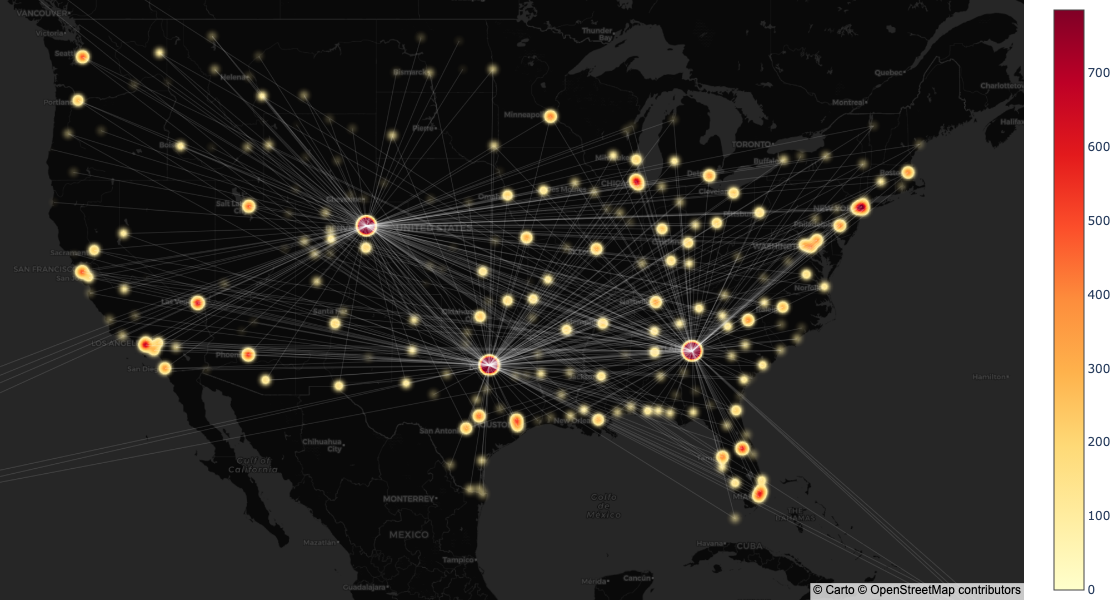

In [45]:
# Create a base map
fig = go.Figure(go.Densitymapbox(
    lat=filtered_flight_counts['Origin_Latitude'],
    lon=filtered_flight_counts['Origin_Longitude'],
    z=filtered_flight_counts['Count'],
    radius=10,
    colorscale="YlOrRd",
    zmin=0,
    zmax=filtered_flight_counts['Count'].max(),
))

# Add lines (with reduced opacity and simplified scaling)
for i, row in filtered_flight_counts.iterrows():
    fig.add_trace(go.Scattermapbox(
        lon=[row['Origin_Longitude'], row['Dest_Longitude']],
        lat=[row['Origin_Latitude'], row['Dest_Latitude']],
        mode='lines',
        line=dict(width=1, color='rgba(255, 255, 255, 0.3)') ,  # Fixed width to reduce complexity
        opacity=0.2,  # Reduced opacity
        showlegend=False
    ))

# Add Scattermapbox trace for airport codes
fig.add_trace(go.Scattermapbox(
    lat=filtered_flight_counts['Origin_Latitude'],
    lon=filtered_flight_counts['Origin_Longitude'],
    mode='markers',  # Set mode to markers
    marker=dict(
        size=0  # Set marker size to 0 to make them invisible but still clickable
    ),
    text=filtered_flight_counts['Origin'],  # Display airport codes on hover
    hoverinfo='text',  # Show only the text on hover
    name='Airport Codes'  # Name the trace for clarity
))

fig.update_layout(
    mapbox_style="carto-darkmatter",
    mapbox=dict(
        center=dict(
            lat=filtered_flight_counts['Origin_Latitude'].mean(),
            lon=filtered_flight_counts['Origin_Longitude'].mean()
        ),
        zoom=3.5
    ),
    showlegend=False,
    margin=dict(l=0, r=0, t=0, b=0),
    height=600
)

fig.show()

## Total Flights vs Delay Distribution

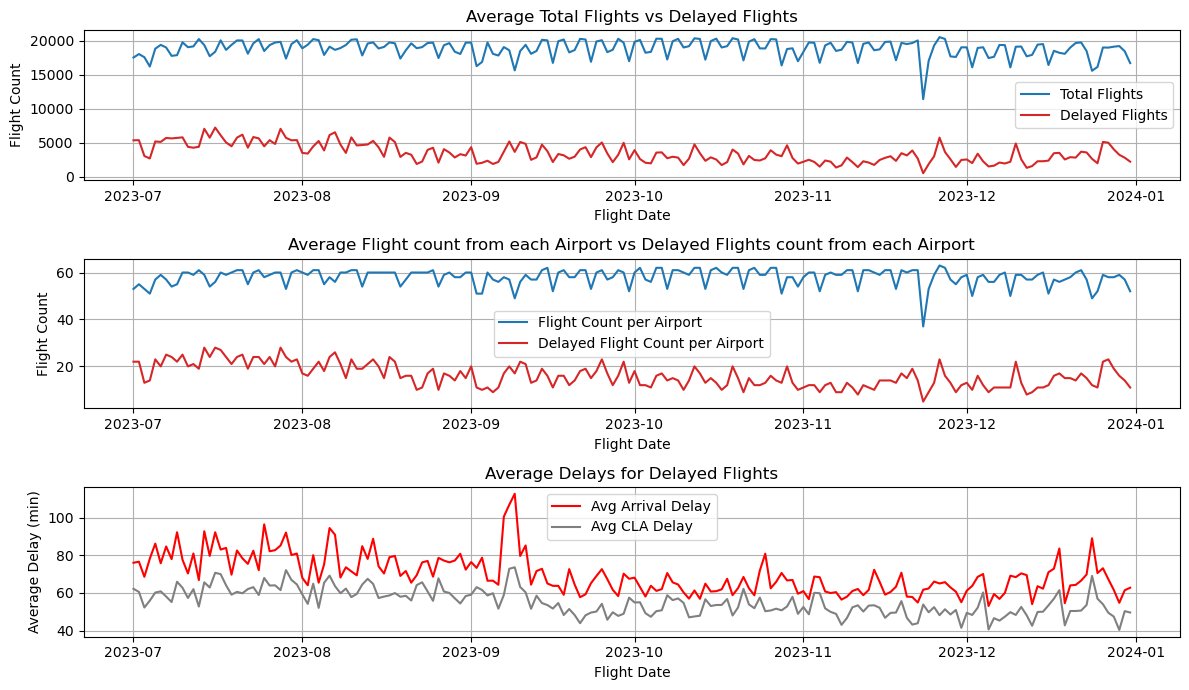

In [103]:
def categorise_on_time_performance(arrival_delay):
    return 'Delayed' if arrival_delay > 15 else 'Not Delayed'

data_cleaned['type'] = data_cleaned['ArrDelay'].astype(int).apply(categorise_on_time_performance)

data_cpy = data_cleaned.copy()

# Group by flight_date , then calculate the total flights count
total_flights_grouped = data_cpy.groupby(['FlightDate'])['Month'].count().reset_index()

# Group by flight_date, AIRPORT, then calculate the total flights count
total_AIRPORT_flights_grouped = data_cpy.groupby(['FlightDate','DestAirportID'])['Month'].count().reset_index()
total_AIRPORT_flights_grouped = total_AIRPORT_flights_grouped.groupby(['FlightDate'])['Month'].mean().round().reset_index()

# Group by flight_date and type, then calculate the total delayed flights count
total_delayed_flights_grouped = data_cpy.groupby(['FlightDate','type'])['Month'].count().reset_index()
total_delayed_count = total_delayed_flights_grouped[total_delayed_flights_grouped['type'] == 'Delayed']

# Group by flight_date, AIRPORT and type, then calculate the total delayed flights count
total_AIRPORT_delayed_flights_grouped = data_cpy.groupby(['FlightDate','DestAirportID','type'])['Month'].count().reset_index()
total_AIRPORT_delayed_count = total_AIRPORT_delayed_flights_grouped[total_AIRPORT_delayed_flights_grouped['type'] == 'Delayed']
total_AIRPORT_delayed_count = total_AIRPORT_delayed_count.groupby(['FlightDate'])['Month'].mean().round().reset_index()

# Group by flight_date and type, then calculate the average ArrDelay
total_delay_grouped = data_cpy.groupby(['FlightDate', 'type'])['ArrDelay'].mean().reset_index()
total_delayed = total_delay_grouped[total_delay_grouped['type'] == 'Delayed']

# Group by flight_date and type, then calculate the average ArrDelay
cla_delay_grouped = data_cpy.groupby(['FlightDate', 'type'])['CLADelay'].mean().reset_index()
cla_delayed = cla_delay_grouped[cla_delay_grouped['type'] == 'Delayed']

# Create plots
plt.figure(figsize=(12, 7))

# Plot for Total flights count and Total Delayed flights count
plt.subplot(3, 1, 1)
plt.plot(total_flights_grouped['FlightDate'], total_flights_grouped['Month'], color='#1f77b4', label='Total Flights')
plt.plot(total_delayed_count['FlightDate'], total_delayed_count['Month'], color='#d62728', label='Delayed Flights')
plt.title('Average Total Flights vs Delayed Flights')
plt.xlabel('Flight Date')
plt.ylabel('Flight Count')
plt.legend()
plt.grid(True)

# Plot for Total flights count and Total Delayed flights count
plt.subplot(3, 1, 2)
plt.plot(total_AIRPORT_flights_grouped['FlightDate'], total_AIRPORT_flights_grouped['Month'], color='#1f77b4', label='Flight Count per Airport')
plt.plot(total_AIRPORT_delayed_count['FlightDate'], total_AIRPORT_delayed_count['Month'], color='#d62728', label='Delayed Flight Count per Airport')
plt.title('Average Flight count from each Airport vs Delayed Flights count from each Airport')
plt.xlabel('Flight Date')
plt.ylabel('Flight Count')
plt.legend()
plt.grid(True)


# Plot for Average Delay and Average CLA Delay for Delayed flights
plt.subplot(3, 1, 3)
plt.plot(total_delayed['FlightDate'], total_delayed['ArrDelay'], color='red', label='Avg Arrival Delay')
plt.plot(cla_delayed['FlightDate'], cla_delayed['CLADelay'], color='gray', label='Avg CLA Delay')
plt.title('Average Delays for Delayed Flights')
plt.xlabel('Flight Date')
plt.ylabel('Average Delay (min)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Delayed Flights Distribution

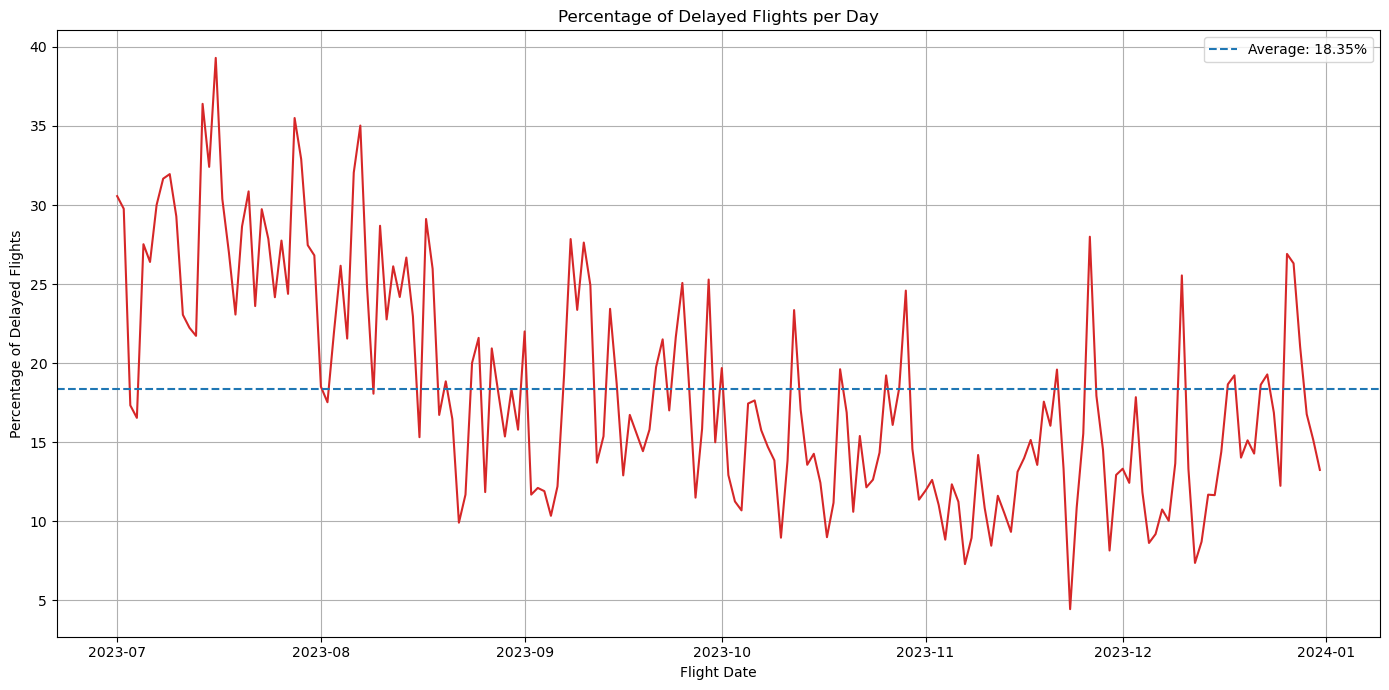

The average percentage of flights delayed on a day is: 18.35%


In [105]:
data_cpy = data_cleaned.copy()

# Group by flight_date and calculate total flights and delayed flights
flight_stats = data_cpy.groupby('FlightDate').agg({
    'type': ['count', lambda x: (x == 'Delayed').sum()]
}).reset_index()

flight_stats.columns = ['FlightDate', 'TotalFlights', 'DelayedFlights']

# Calculate percentage of delayed flights
flight_stats['PercentDelayed'] = (flight_stats['DelayedFlights'] / flight_stats['TotalFlights']) * 100
avg_percent_delayed = flight_stats['PercentDelayed'].mean()

# Create plot
plt.figure(figsize=(14, 7))
plt.plot(flight_stats['FlightDate'], flight_stats['PercentDelayed'], color='#d62728')
plt.axhline(y=avg_percent_delayed, color='#1f77b4', linestyle='--', label=f'Average: {avg_percent_delayed:.2f}%')
plt.title('Percentage of Delayed Flights per Day')
plt.xlabel('Flight Date')
plt.ylabel('Percentage of Delayed Flights')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"The average percentage of flights delayed on a day is: {avg_percent_delayed:.2f}%")

## Understanding Delay Distribution

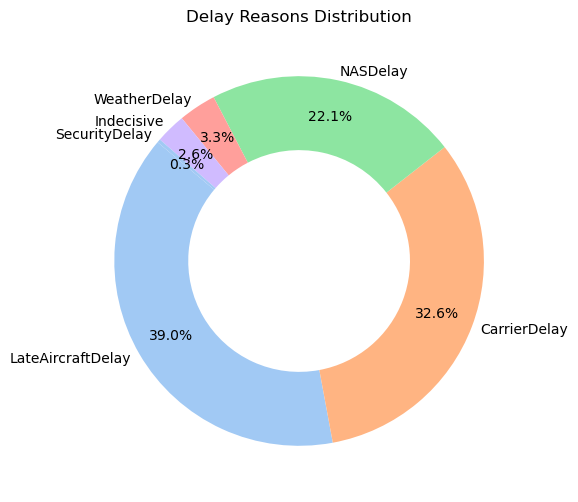

In [107]:
def categorise_delay_reason(c, w, n, s, l, delay):
    # Check if the total delay is greater than 0 to avoid division by zero
    if delay > 15:
        # Determine if any of the delays constitute more than 50% of the total delay
        if c > 0.5 * delay:
            return 'CarrierDelay'
        elif w > 0.5 * delay:
            return 'WeatherDelay'
        elif n > 0.5 * delay:
            return 'NASDelay'
        elif s > 0.5 * delay:
            return 'SecurityDelay'
        elif l > 0.5 * delay:
            return 'LateAircraftDelay'
        else:
            return 'Indecisive'  # If no individual delay is more than 50% of the total delay
    else:
        return 'NoDelay'  # If the total delay is 0 or negative

# data_cleaned = data.copy()
data_cpyy = data_cleaned[data_cleaned['ArrDelay'] > 15]
data_cpyy['delay_reason'] = data_cpyy.apply(lambda x: categorise_delay_reason(x['CarrierDelay'], x['WeatherDelay'], x['NASDelay'], x['SecurityDelay'], x['LateAircraftDelay'], x['ArrDelay']), axis=1)

# Count the occurrences of each delay reason
delay_counts = data_cpyy['delay_reason'].value_counts()

plt.figure(figsize=(10, 6))

# Create a pie chart with percentages and labels at the side
plt.pie(delay_counts, 
        labels=delay_counts.index, 
        autopct='%1.1f%%', 
        colors=sns.color_palette('pastel')[0:5], 
        labeldistance=1.05,  
        pctdistance=0.8,   
        startangle=140,  
        wedgeprops=dict(width=0.4) 
       )

plt.title('Delay Reasons Distribution')
plt.show()

## Correlations between Total Delay & Individual Delays

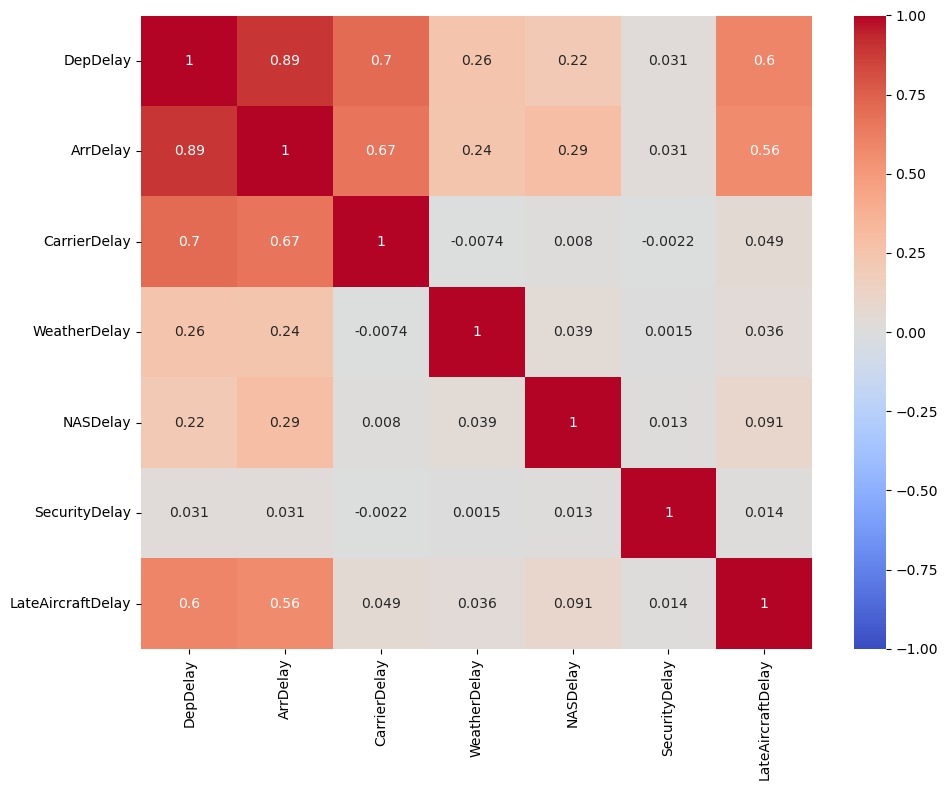

In [108]:
delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
correlation_matrix = data_cleaned[['DepDelay', 'ArrDelay'] + delay_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
# plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

## Temporal Patterns

<Figure size 600x300 with 0 Axes>

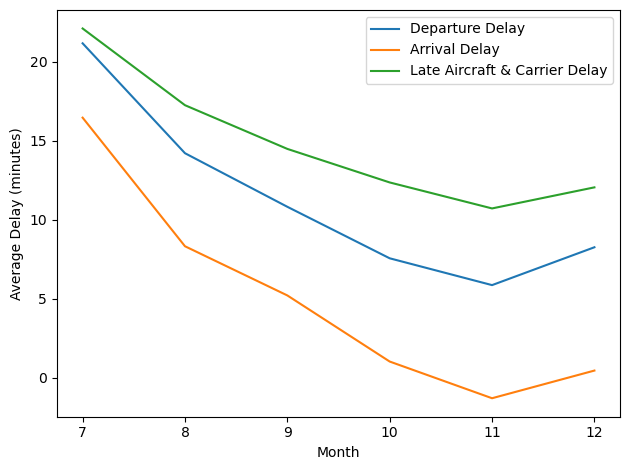

<Figure size 600x300 with 0 Axes>

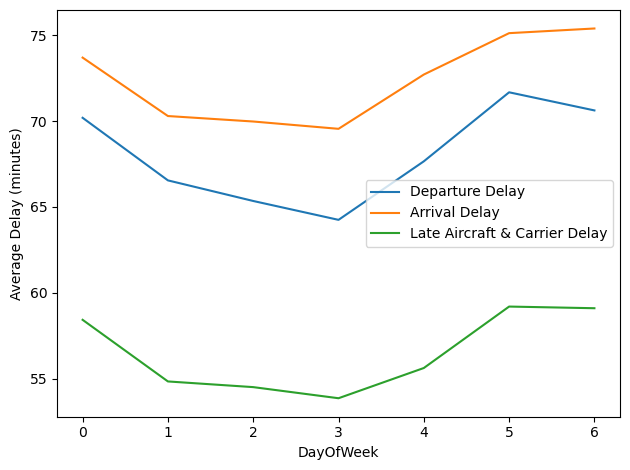

<Figure size 600x300 with 0 Axes>

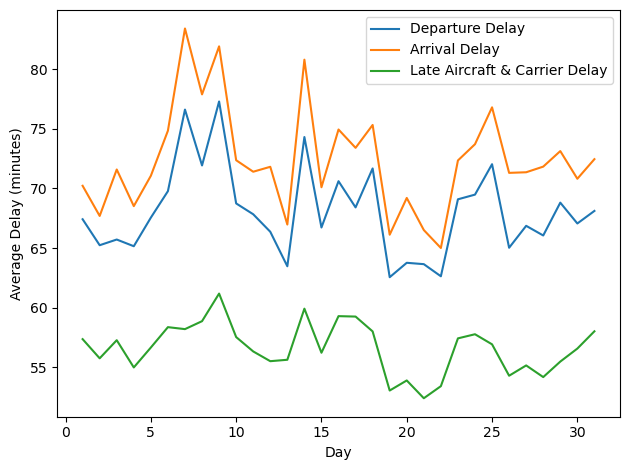

In [113]:
data_cpy = data_cleaned.copy()
# Delays over time - Month
monthly_delays = data_cpy.groupby(['Month'])[['DepDelay', 'ArrDelay','CLADelay']].mean()
plt.figure(figsize=(6, 3))
monthly_delays.plot()
# plt.title('Average Delays over Time')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.legend(['Departure Delay', 'Arrival Delay', 'Late Aircraft & Carrier Delay'])
plt.tight_layout()
plt.show()

#Delays over time - DOW
dow_delays = data_cpyy.groupby(['DayOfWeek'])[['DepDelay', 'ArrDelay','CLADelay']].mean()
plt.figure(figsize=(6, 3))
dow_delays.plot()
# plt.title('Average Delays over Time')
plt.xlabel('DayOfWeek')
plt.ylabel('Average Delay (minutes)')
plt.legend(['Departure Delay', 'Arrival Delay', 'Late Aircraft & Carrier Delay'])
plt.tight_layout()
plt.show()

#Delays over time - Day
daily_delays = data_cpyy.groupby(['Day'])[['DepDelay', 'ArrDelay','CLADelay']].mean()
plt.figure(figsize=(6, 3))
daily_delays.plot()
# plt.title('Average Delays over Time')
plt.xlabel('Day')
plt.ylabel('Average Delay (minutes)')
plt.legend(['Departure Delay', 'Arrival Delay', 'Late Aircraft & Carrier Delay'])
plt.tight_layout()
plt.show()

In [115]:
np.round(data_cleaned[['DepDelay','ArrDelay','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','Distance']].describe())

,DepDelay,ArrDelay,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Distance
count,3468783.0,3468783.0,3468783.0,3468783.0,3468783.0,3468783.0,3468783.0,3468783.0
mean,11.0,5.0,5.0,1.0,4.0,0.0,10.0,837.0
std,54.0,61.0,37.0,13.0,15.0,1.0,31.0,600.0
min,-99.0,-1423.0,0.0,0.0,0.0,0.0,0.0,21.0
25%,-6.0,-15.0,0.0,0.0,0.0,0.0,0.0,399.0
50%,-2.0,-7.0,0.0,0.0,0.0,0.0,0.0,680.0
75%,8.0,8.0,0.0,0.0,0.0,0.0,5.0,1069.0
max,3786.0,3795.0,3786.0,1860.0,1651.0,805.0,2586.0,5095.0


## Feature Extraction (Common)

In [130]:
def convert_to_timedelta(hhmm):
    # Convert the input to a string and pad with leading zeros to ensure it's always 4 digits
    hhmm_str = str(hhmm).zfill(4)

    # Extract hours and minutes
    hours = int(hhmm_str[:2])
    minutes = int(hhmm_str[2:])
    
    return pd.Timedelta(hours=hours, minutes=minutes)

dataset = data_cleaned.copy()

dataset['CRSArrTimestamp'] = pd.to_datetime(dataset['FlightDate']) + dataset['CRSArrTime'].apply(convert_to_timedelta)
dataset['CRSDepTimestamp'] = pd.to_datetime(dataset['FlightDate']) + dataset['CRSDepTime'].apply(convert_to_timedelta)

dataset = dataset.sort_values(by=['CRSDepTimestamp'])

# AIRLINE EFFECT: one hot encoding airline number
dataset = pd.get_dummies(dataset, columns=['IATA_CODE_Reporting_Airline'])
created_feature_names = [col for col in dataset.columns if col.startswith('IATA_CODE_Reporting_Airline_')]

# OD-PAIR EFFECT : frequency encoding
dataset['OD_pair'] = dataset['Origin'] + dataset['Dest']
frequency_encoding = dataset['OD_pair'].value_counts(normalize=False)
dataset['OD_pair'] = dataset['OD_pair'].map(frequency_encoding)

# TN EFFECT 1: wrt departure
dataset['Tail_Number_Timestamp'] = dataset.groupby(['Tail_Number'])['CRSArrTimestamp'].shift(1) 
dataset['tail_number_effect'] = (dataset['CRSDepTimestamp'] - dataset['Tail_Number_Timestamp']).dt.total_seconds() / 60
dataset['tail_number_effect'] = dataset['tail_number_effect'].fillna(dataset['tail_number_effect'].max())

## Data Reduction 

In [131]:
#Average daily count of flights departing from airports
x = dataset.groupby(['DestAirportID','FlightDate']).agg({'Day':'count'}).reset_index().sort_values(by = 'Day')
x = x.groupby('DestAirportID').agg({'Day':'mean'}).reset_index().sort_values(by = 'Day', ascending=False)

print ("Average flight count from an airport a day:", str(round(x['Day'].mean())))
print ("Filtering Airports with daily average flight count greater than", str(round(x['Day'].mean())), "flights a day")
x = x[x['Day']>round(x['Day'].mean())]
airport_data_list = sorted(x['DestAirportID'].unique().tolist())
print ('Total Airports Selected:',len(airport_data_list))
dataset = dataset[dataset['DestAirportID'].isin(airport_data_list)]
dataset = dataset.sort_values(by = ['DestAirportID', 'CRSArrTimestamp'])
dataset = dataset.drop(columns = ['level_0','index'])
print ("Dataset length:", len(dataset))
dataset.head()

Average flight count from an airport a day: 55
Filtering Airports with daily average flight count greater than 55 flights a day
Total Airports Selected: 67
Dataset length: 2956916


,Origin,Dest,OriginCityName,DestCityName,FlightDate,Tail_Number,DOT_ID_Reporting_Airline,Flight_Number_Reporting_Airline,OriginAirportID,DestAirportID,...,IATA_CODE_Reporting_Airline_MQ,IATA_CODE_Reporting_Airline_NK,IATA_CODE_Reporting_Airline_OH,IATA_CODE_Reporting_Airline_OO,IATA_CODE_Reporting_Airline_UA,IATA_CODE_Reporting_Airline_WN,IATA_CODE_Reporting_Airline_YX,OD_pair,Tail_Number_Timestamp,tail_number_effect
130063,LAS,ABQ,"Las Vegas, NV","Albuquerque, NM",2023-07-01,N8685B,19393,3877,12889,10140,...,False,False,False,False,False,True,False,1052,2023-07-01 18:05:00,215.0
129609,DAL,ABQ,"Dallas, TX","Albuquerque, NM",2023-07-01,N7725A,19393,1683,11259,10140,...,False,False,False,False,False,True,False,884,2023-07-01 07:45:00,45.0
1366459,MDW,ABQ,"Chicago, IL","Albuquerque, NM",2023-07-01,N8829Q,19393,428,13232,10140,...,False,False,False,False,False,True,False,210,2023-07-01 06:45:00,60.0
69717,ATL,ABQ,"Atlanta, GA","Albuquerque, NM",2023-07-01,N909DN,19790,1354,10397,10140,...,False,False,False,False,False,False,False,517,2023-07-01 07:20:00,80.0
27933,DFW,ABQ,"Dallas/Fort Worth, TX","Albuquerque, NM",2023-07-01,N878NN,19805,928,11298,10140,...,False,False,False,False,False,False,False,1172,2023-07-01 08:36:00,25.0


# Modelling

## LSTM-Model Architecture

In [126]:
def run_model(X_train, y_train, X_test, y_test):
    # Define parameters
    input_shape = (X_train.shape[1], 1)
    n_features = X_train.shape[1]
    n_timesteps = 1 
    
    # Reshape data to fit LSTM input requirements: (samples, timesteps, features)
    X_train_lstm = np.reshape(X_train, (X_train.shape[0], n_timesteps, n_features))
    X_test_lstm = np.reshape(X_test, (X_test.shape[0], n_timesteps, n_features))
    
    # Create LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape = (n_timesteps, n_features)))
    model.add(Dense(1))  
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train model
    history = model.fit(X_train_lstm, y_train, epochs=20, batch_size=72, validation_data=(X_test_lstm, y_test), verbose=0)
    
    # Evaluate model
    loss = model.evaluate(X_test_lstm, y_test, verbose=0)

    # Predict
    predictions = model.predict(X_test_lstm)

    return model, predictions, loss

## Model Training & Evaluation - All reference times - Both Feature Sets

In [139]:
# Define the reference times (in minutes)
ref_times = [15, 30, 60, 90]

# Define the features and predictor variables
features = ['type','YearMonth','tail_number_effect', 'CarrierDelay', 'CRSArrTimestamp', 'CRSTimestamp', 'Dest', 'ArrDelay', 'DepDelay', 'Origin_Latitude', 'IATA_CODE_Reporting_Airline_HA', 'LateAircraftDelay', 'nearest_departure_after', 'SecurityDelay', 'IATA_CODE_Reporting_Airline_AA', 'Day', 'CRSTime', 'IATA_CODE_Reporting_Airline_MQ', 'flight_type', 'Tail_Number_Timestamp', 'OriginCityName', 'Year', 'IATA_CODE_Reporting_Airline_UA', 'FlightDate', 'IATA_CODE_Reporting_Airline_B6', 'CLADelay', 'nearest_arrival_before', 'OD_pair', 'DayOfWeek', 'Tail_Number', 'ArrTime', 'IATA_CODE_Reporting_Airline_F9', 'Diverted', 'Flight_Number_Reporting_Airline', 'ActualElapsedTime', 'WeatherDelay', 'Distance', 'Cancelled', 'CancellationCode', 'CRSElapsedTime', 'CRSDepTime', 'IATA_CODE_Reporting_Airline_NK', 'CRSTimestampType', 'IATA_CODE_Reporting_Airline_WN', 'NASDelay', 'DestCityName', 'Dest_Longitude', 'DepTime', 'nearest_arrival_after', 'Dest_Latitude', 'IATA_CODE_Reporting_Airline_DL', 'OriginAirportID', 'IATA_CODE_Reporting_Airline_OO', 'IATA_CODE_Reporting_Airline_YX', 'IATA_CODE_Reporting_Airline_9E', 'DestAirportID', 'CRSArrTime', 'Origin', 'IATA_CODE_Reporting_Airline_AS', 'IATA_CODE_Reporting_Airline_G4', 'Month', 'Origin_Longitude', 'IATA_CODE_Reporting_Airline_OH', 'nearest_departure_before', 'DOT_ID_Reporting_Airline', 'ActualDepTimestamp', 'CRSDepTimestamp']
final_results_a1 = pd.DataFrame(columns = features)

# Define the features and predictor variables
features = ['type','YearMonth','tail_number_effect', 'CarrierDelay', 'CRSArrTimestamp', 'Dest', 'ArrDelay', 'DepDelay', 'Origin_Latitude', 'IATA_CODE_Reporting_Airline_HA', 'LateAircraftDelay', 'SecurityDelay', 'IATA_CODE_Reporting_Airline_AA', 'Day', 'CRSTime', 'IATA_CODE_Reporting_Airline_MQ', 'Tail_Number_Timestamp', 'OriginCityName', 'Year', 'IATA_CODE_Reporting_Airline_UA', 'FlightDate', 'IATA_CODE_Reporting_Airline_B6', 'CLADelay', 'ActualArrTimestamp_CLADelay', 'OD_pair', 'TN_PrevArrTimestamp', 'DayOfWeek', 'Tail_Number', 'ArrTime', 'IATA_CODE_Reporting_Airline_F9', 'RefDepDelay', 'Diverted', 'Flight_Number_Reporting_Airline', 'ActualElapsedTime', 'WeatherDelay', 'Distance', 'Cancelled', 'CancellationCode', 'CRSElapsedTime', 'CRSDepTime', 'IATA_CODE_Reporting_Airline_NK', 'IATA_CODE_Reporting_Airline_WN', 'NASDelay', 'DestCityName', 'Dest_Longitude', 'DepTime', 'Dest_Latitude', 'IATA_CODE_Reporting_Airline_DL', 'OriginAirportID', 'IATA_CODE_Reporting_Airline_OO', 'IATA_CODE_Reporting_Airline_YX', 'IATA_CODE_Reporting_Airline_9E', 'DestAirportID', 'CRSArrTime', 'Origin', 'IATA_CODE_Reporting_Airline_AS', 'IATA_CODE_Reporting_Airline_G4', 'Month', 'Origin_Longitude', 'IATA_CODE_Reporting_Airline_OH', 'DOT_ID_Reporting_Airline', 'ActualDepTimestamp', 'CRSDepTimestamp']
final_results_a2 = pd.DataFrame(columns = features)

approach_results = {ref_time: {} for ref_time in ref_times}

# Loop over each ref_time interval
for ref_time in tqdm(ref_times, total=len(ref_times), desc=f"Processing data for ref times"):
    dataset_cpy = dataset.copy()

    # Common Features for both approaches -- RefAt, RefDepDelay
    # Sort dataset_cpy for next feature extraction
    dataset_cpy = dataset_cpy.sort_values(by=['CRSArrTimestamp'])
    # TN EFFECT 2: Delay caused by tail number (tail_number_REF_effect)
    dataset_cpy['RefAt'] = dataset_cpy['CRSArrTimestamp'] - pd.Timedelta(minutes=int(ref_time))    
    
    # Sort dataset_cpy for RefDepDelay extraction
    dataset_cpy = dataset_cpy.sort_values(by=['DestAirportID', 'CRSArrTimestamp'])
    # DEP DELAY EFFECT (RefDepDelay)
    dataset_cpy['ActualDepTimestamp'] = dataset_cpy['CRSDepTimestamp'] + pd.to_timedelta(dataset_cpy['DepDelay'], unit='m')
    dataset_cpy['RefDepDelay'] = np.where(
        dataset_cpy['ActualDepTimestamp'] > dataset_cpy['RefAt'],
        np.maximum((dataset_cpy['RefAt'] - dataset_cpy['CRSDepTimestamp']).dt.total_seconds() / 60, 0),
        np.maximum((dataset_cpy['ActualDepTimestamp'] - dataset_cpy['CRSDepTimestamp']).dt.total_seconds() / 60, 0)
    )

    print (f"Extracted Common Features for both approaches Ref {ref_time} minutes")
    print ("--------------------------------------------------------")
    
    # Train and evaluate models for both approaches
    for approach in [1, 2]:
        
        if approach == 1:
            print (f"Applying model using Approach 1 Ref {ref_time} minutes!")
            airport_model_list = []
            final_pred_df = pd.DataFrame()
            
            # Approach 1 - Process each airport
            for airport in airport_data_list[0:5]:
                 
                # Filter dataset_cpy for specific airport
                lstm_df = dataset_cpy[(dataset_cpy['OriginAirportID'] == airport) | (dataset_cpy['DestAirportID'] == airport)].copy()
                lstm_df['CRSTimestamp'] = np.where(lstm_df['DestAirportID'] == airport, lstm_df['CRSArrTimestamp'], lstm_df['CRSDepTimestamp'])
                lstm_df['CRSTimestampType'] = np.where(lstm_df['DestAirportID'] == airport, 'Arrival', 'Departure')
                lstm_df = lstm_df.sort_values(by=['CRSTimestamp'])
                
                # Nearest flights features
                lstm_df['nearest_arrival_before'] = lstm_df[lstm_df['DestAirportID'] == airport].groupby(['DestAirportID'])['CRSArrTimestamp'].shift(1)
                lstm_df['nearest_arrival_before'] = lstm_df['nearest_arrival_before'].bfill().ffill()
                lstm_df['nearest_arrival_before'] = (lstm_df['nearest_arrival_before'] - lstm_df['CRSTimestamp']).dt.total_seconds() / 60
                lstm_df['nearest_arrival_after'] = lstm_df[lstm_df['DestAirportID'] == airport].groupby(['DestAirportID'])['CRSArrTimestamp'].shift(-1)
                lstm_df['nearest_arrival_after'] = lstm_df['nearest_arrival_after'].ffill().bfill()
                lstm_df['nearest_arrival_after'] = (lstm_df['nearest_arrival_after'] - lstm_df['CRSTimestamp']).dt.total_seconds() / 60
                lstm_df['nearest_departure_before'] = lstm_df[lstm_df['OriginAirportID'] == airport].groupby(['OriginAirportID'])['CRSDepTimestamp'].shift(1)
                lstm_df['nearest_departure_before'] = lstm_df['nearest_departure_before'].ffill().bfill()
                lstm_df['nearest_departure_before'] = (lstm_df['nearest_departure_before'] - lstm_df['CRSTimestamp']).dt.total_seconds() / 60
                lstm_df['nearest_departure_after'] = lstm_df[lstm_df['OriginAirportID'] == airport].groupby(['OriginAirportID'])['CRSDepTimestamp'].shift(-1)
                lstm_df['nearest_departure_after'] = lstm_df['nearest_departure_after'].bfill().ffill()
                lstm_df['nearest_departure_after'] = (lstm_df['nearest_departure_after'] - lstm_df['CRSTimestamp']).dt.total_seconds() / 60
                
                # Additional features
                lstm_df['CRSTime'] = lstm_df['CRSTimestamp'].dt.hour + lstm_df['CRSTimestamp'].dt.minute / 60
                lstm_df['flight_type'] = np.where(lstm_df['DestAirportID'] == airport, 1, -1)
                
                features = ['OD_pair', 'CRSTime', 'DayOfWeek', 'Month', 'flight_type', 'nearest_arrival_before', 'nearest_arrival_after', 
                            'nearest_departure_before', 'nearest_departure_after', 'RefDepDelay'] + created_feature_names
                predictor = ['CLADelay']
                
                # Train-test split
                split_len = int(len(lstm_df) * 0.8)
                X_train, y_train = lstm_df.iloc[:split_len][features], lstm_df.iloc[:split_len][predictor]
                X_test, y_test = lstm_df.iloc[split_len:][features], lstm_df.iloc[split_len:][predictor]
                pred_df = lstm_df.iloc[split_len:]
                
                # Scaling
                scaler_x, scaler_y = StandardScaler(), StandardScaler()
                X_train_scaled = scaler_x.fit_transform(X_train)
                X_test_scaled = scaler_x.transform(X_test)
                y_train_scaled = scaler_y.fit_transform(y_train)
                y_test_scaled = scaler_y.transform(y_test)
                
                # Train the model and make predictions
                airport_model, airport_predictions, airport_loss = run_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)
                airport_model_list.append(airport_model)
                pred_col_name = 'Pred_ArrDelay' + str(ref_time)
                pred_df[pred_col_name] = scaler_y.inverse_transform(airport_predictions)
                pred_df = pred_df.drop(columns = ['RefDepDelay', 'RefAt'])
                final_pred_df = pd.concat([final_pred_df, pred_df])

                columns = list(set(pred_df.columns.tolist()) - set([pred_col_name]))

            final_results_a1 = pd.merge(final_results_a1, final_pred_df, how = 'outer', on = columns)
            
            # Calculate performance metrics
            rmse = np.sqrt(mean_squared_error(final_pred_df['CLADelay'], final_pred_df['Pred_ArrDelay'+str(ref_time)]))
            mae = mean_absolute_error(final_pred_df['CLADelay'], final_pred_df['Pred_ArrDelay'+str(ref_time)])
            
            # Store the metrics for this airport
            approach_results[ref_time][approach] = {
                'RMSE': round(rmse,4),
                'MAE': round(mae,4)
            }

            print (f"Modelling Approach 1  Ref {ref_time} minutes COMPLETED!")
            print ("--------------------------------------------------------")
            
        elif approach == 2:
            print (f"Applying model using Approach 2 Ref {ref_time} minutes!")

            # Approach 2 - Extracting Tail Number specific features
            dataset_cpy = dataset_cpy.sort_values(by = ['CRSArrTimestamp'])
            dataset_cpy['ActualArrTimestamp_CLADelay'] = dataset_cpy['CRSArrTimestamp'] + pd.to_timedelta(dataset_cpy['LateAircraftDelay'] + dataset_cpy['CarrierDelay'], unit='m')
            dataset_cpy['TN_PrevArrTimestamp'] = dataset_cpy.groupby(['Tail_Number'])['ActualArrTimestamp_CLADelay'].shift(1)
            dataset_cpy['tail_number_REF_effect'] = np.where(
                dataset_cpy['TN_PrevArrTimestamp'] > dataset_cpy['RefAt'],
                (dataset_cpy['RefAt'] - dataset_cpy['Tail_Number_Timestamp']).dt.total_seconds() / 60,
                (dataset_cpy['TN_PrevArrTimestamp'] - dataset_cpy['Tail_Number_Timestamp']).dt.total_seconds() / 60
            )
            dataset_cpy['tail_number_REF_effect'] = dataset_cpy['tail_number_REF_effect'].fillna(dataset_cpy.groupby('Tail_Number')['tail_number_REF_effect'].transform('max'))
            dataset_cpy['tail_number_REF_effect'] = dataset_cpy['tail_number_REF_effect'].fillna(dataset_cpy['tail_number_REF_effect'].max())


            TN_count =  dataset_cpy[dataset_cpy['Tail_Number'].isin(['N264LV','N957WN','N928WN', 'N476HA','N483HA'])]
            tn_model_list = []
            final_pred_df_f2 = pd.DataFrame()
        
            # Iterate over the top 5 RANDOMLY SELECTED tail numbers
            for i, tn in TN_count.head(5).iterrows():
                
                # Filter dataset for a specific tail number
                tn_data = dataset_cpy[dataset_cpy['Tail_Number'] == tn['Tail_Number']].copy()
                tn_data = tn_data.sort_values('CRSDepTimestamp')
                if i <=5:
                    print (1, len(tn_data))
        
                # Additional features (temporal features)
                tn_data['CRSTime'] = tn_data['CRSDepTimestamp'].dt.hour + tn_data['CRSDepTimestamp'].dt.minute / 60
        
                # Define the features and predictor variables
                features = ['CRSTime', 'DayOfWeek', 'Month', 'OD_pair', 'tail_number_effect', 
                            'RefDepDelay', 'tail_number_REF_effect'] + created_feature_names
                predictor = ['CLADelay']
        
                # Split the dataset into training and testing sets (80% train, 20% test)
                split_len = int(len(tn_data) * 0.8)
                X_train, y_train = tn_data.iloc[:split_len][features], tn_data.iloc[:split_len][predictor]
                X_test, y_test = tn_data.iloc[split_len:][features], tn_data.iloc[split_len:][predictor]
                pred_df = tn_data.iloc[split_len:]
        
                # Scale the features and target variable
                scaler_x, scaler_y = StandardScaler(), StandardScaler()
                X_train_scaled = scaler_x.fit_transform(X_train)
                X_test_scaled = scaler_x.transform(X_test)
                y_train_scaled = scaler_y.fit_transform(y_train)
                y_test_scaled = scaler_y.transform(y_test)
        
                # Train the model and make predictions
                tn_model, tn_predictions, tn_loss = run_model(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled)

                pred_col_name = 'Pred_ArrDelay'+str(ref_time)
                # Inverse scaling of predictions and store them in the dataframe
                pred_df[pred_col_name] = np.round(scaler_y.inverse_transform(tn_predictions), 0)
                pred_df = pred_df.drop(columns = ['RefAt','tail_number_REF_effect'])
                # Append the trained model and predictions to the respective lists
                tn_model_list.append(tn_model)
                final_pred_df_f2 = pd.concat([final_pred_df_f2, pred_df])
                columns = list(set(pred_df.columns.tolist()) - set([pred_col_name]))

            final_results_a2 = pd.merge(final_results_a2, final_pred_df_f2, how = 'outer', on = columns)
            
            # After processing all tail numbers, calculate and store performance metrics
            rmse = np.sqrt(mean_squared_error(final_pred_df_f2['CLADelay'], final_pred_df_f2['Pred_ArrDelay'+str(ref_time)]))
            mae = mean_absolute_error(final_pred_df_f2['CLADelay'], final_pred_df_f2['Pred_ArrDelay'+str(ref_time)])
        
            # Store metrics for this approach and ref_time
            approach_results[ref_time][approach] = {
                'RMSE': round(rmse,4),
                'MAE': round(mae,4)
            }

            print (f"Modelling Approach 2  Ref {ref_time} minutes COMPLETED!")
            print ("===============================================================================================")

Processing data for ref times:   0%|                      | 0/4 [00:00<?, ?it/s]

Extracted Common Features for both approaches Ref 15 minutes
--------------------------------------------------------
Applying model using Approach 1 Ref 15 minutes!
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
Modelling Approach 1  Ref 15 minutes COMPLETED!
--------------------------------------------------------
Applying model using Approach 2 Ref 15 minutes!
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Processing data for ref times:  25%|███▌          | 1/4 [01:12<03:38, 72.76s/it]

Modelling Approach 2  Ref 15 minutes COMPLETED!
Extracted Common Features for both approaches Ref 30 minutes
--------------------------------------------------------
Applying model using Approach 1 Ref 30 minutes!
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 1s 281us/step
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
Modelling Approach 1  Ref 30 minutes COMPLETED!
--------------------------------------------------------
Applying model using Approach 2 Ref 30 minutes!
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Processing data for ref times:  50%|███████       | 2/4 [02:23<02:23, 71.85s/it]

Modelling Approach 2  Ref 30 minutes COMPLETED!
Extracted Common Features for both approaches Ref 60 minutes
--------------------------------------------------------
Applying model using Approach 1 Ref 60 minutes!
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
Modelling Approach 1  Ref 60 minutes COMPLETED!
--------------------------------------------------------
Applying model using Approach 2 Ref 60 minutes!
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Processing data for ref times:  75%|██████████▌   | 3/4 [03:34<01:11, 71.31s/it]

Modelling Approach 2  Ref 60 minutes COMPLETED!
Extracted Common Features for both approaches Ref 90 minutes
--------------------------------------------------------
Applying model using Approach 1 Ref 90 minutes!
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 241us/step
575/575 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step
593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step
Modelling Approach 1  Ref 90 minutes COMPLETED!
--------------------------------------------------------
Applying model using Approach 2 Ref 90 minutes!
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


Processing data for ref times: 100%|██████████████| 4/4 [04:46<00:00, 71.59s/it]

Modelling Approach 2  Ref 90 minutes COMPLETED!


## Results

In [141]:
# Flatten the dictionary structure into a list of rows for the DataFrame
metric_data = []
for ref_time, models in approach_results.items():
    for model_num, metrics in models.items():
        row = {'Ref_Time': ref_time, 'Model': model_num}
        row.update(metrics)  # Add RMSE, MAE metrics
        metric_data.append(row)

metric_df = pd.DataFrame(metric_data)
metric_df.sort_values(by = ['Ref_Time','Model'])

,Ref_Time,Model,RMSE,MAE
0,15,1,31.2319,10.0642
1,15,2,17.1668,10.6271
2,30,1,32.1982,10.7092
3,30,2,18.1250,10.6508
4,60,1,34.1157,10.7901
5,60,2,21.2338,13.4204
6,90,1,36.1751,12.2566
7,90,2,21.9228,14.0584


## F1-plots

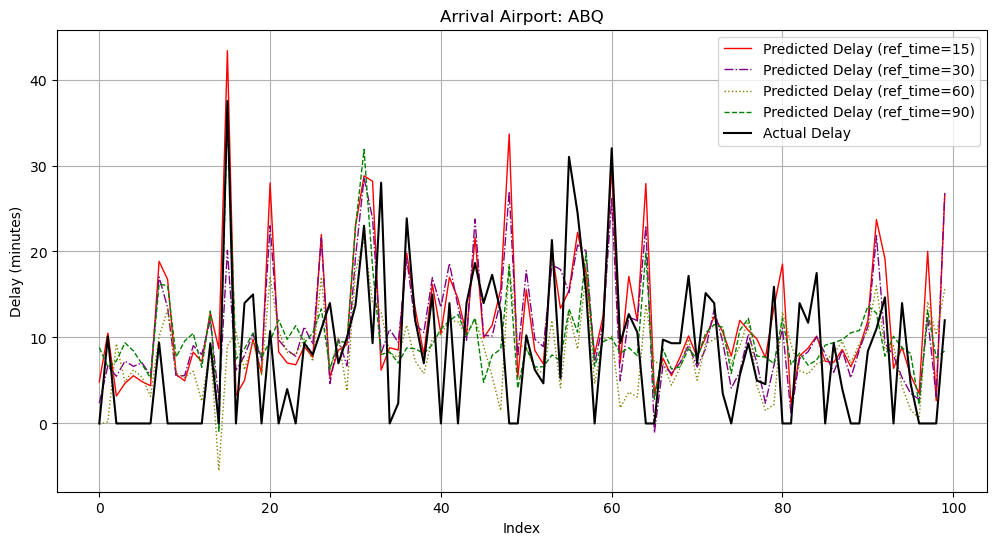

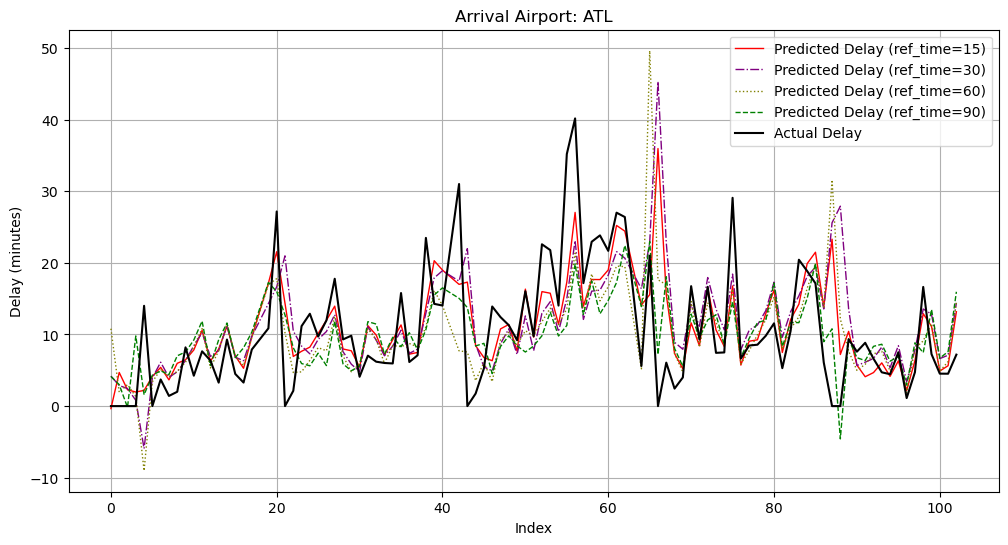

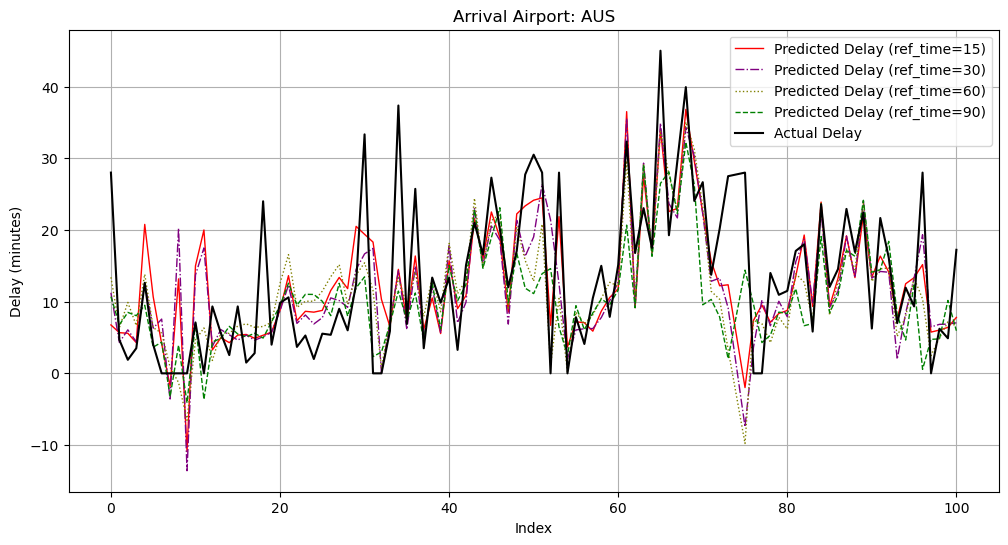

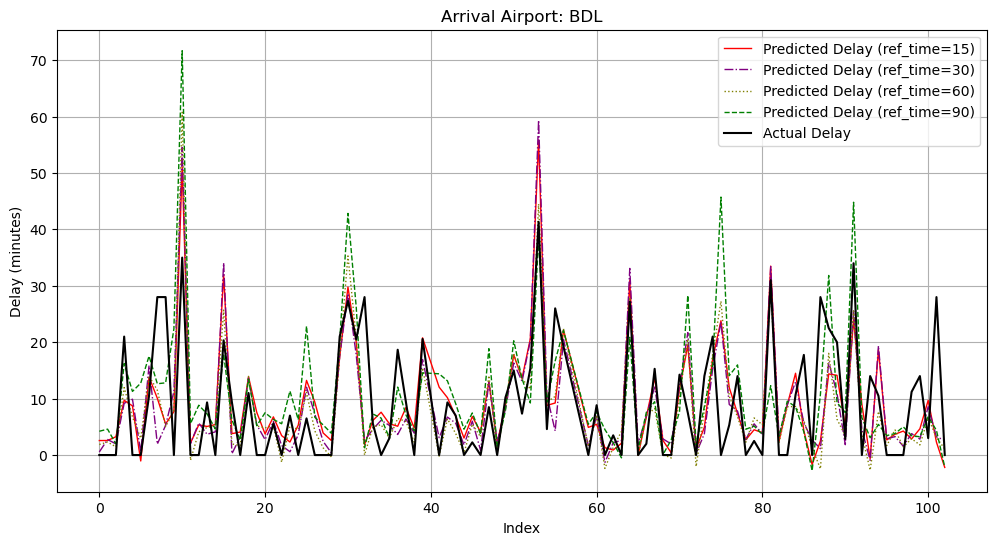

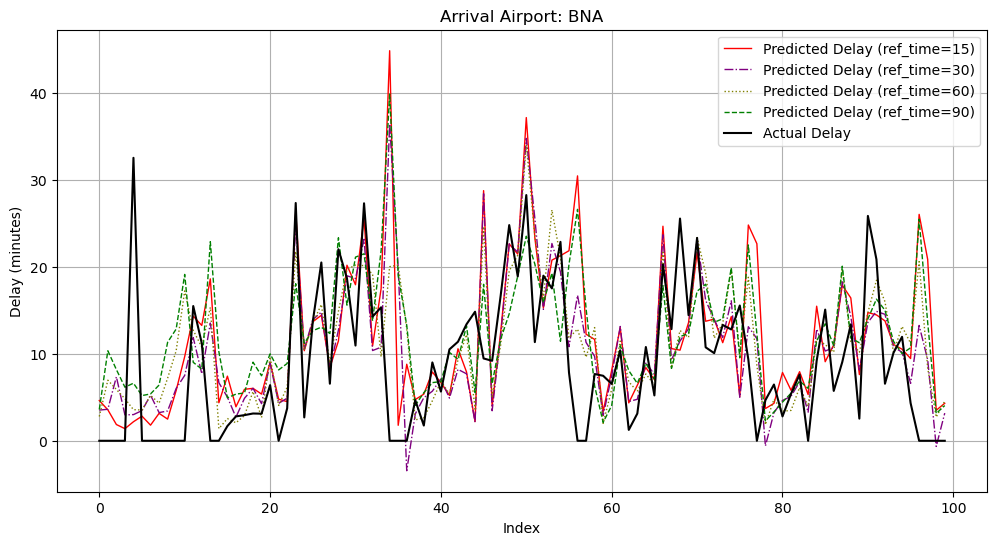

In [145]:
final_results_a1['CRSArrHour'] = final_results_a1['CRSArrTimestamp'].dt.hour
final_pred_agg_a1 = final_results_a1.groupby(['DestAirportID', 'Dest', 'FlightDate', 'CRSArrHour']).agg({'CLADelay': 'mean', 'Pred_ArrDelay15': 'mean', 'Pred_ArrDelay30': 'mean', 'Pred_ArrDelay60': 'mean', 'Pred_ArrDelay90': 'mean'}).reset_index()

airports = []
for airport in airport_data_list[:5]:
    airports.append(airport)
    row = final_pred_agg_a1[final_pred_agg_a1['DestAirportID'] == airport].copy().reset_index()
    row = row[row['CLADelay']<=60]
    airport = row['Dest'].unique()[0]
    
    plt.figure(figsize=(12, 6))

    # Loop through different reference times with improved visual differentiation
    for ref_time, color, style in zip([15, 30, 60, 90], ['red', 'purple', 'OLIVE', 'green'], ['-', '-.', ':', '--']):
        plt.plot(
            row[0:100].index, 
            row[0:100]['Pred_ArrDelay' + str(ref_time)], 
            label=f'Predicted Delay (ref_time={ref_time})', 
            linestyle=style, 
            color=color, 
            linewidth=1, 
            # alpha=0.8
        )

    # Plot the actual delay
    plt.plot(row[0:100].index, row[0:100]['CLADelay'], label='Actual Delay', color='black', linewidth=1.5)

    
    plt.title(f'Arrival Airport: {airport}')
    plt.xlabel('Index')
    plt.ylabel('Delay (minutes)')
    plt.legend()
    plt.grid(True)
    plt.show()


## F2-plots

['N928WN', 'N476HA', 'N483HA', 'N957WN', 'N264LV']


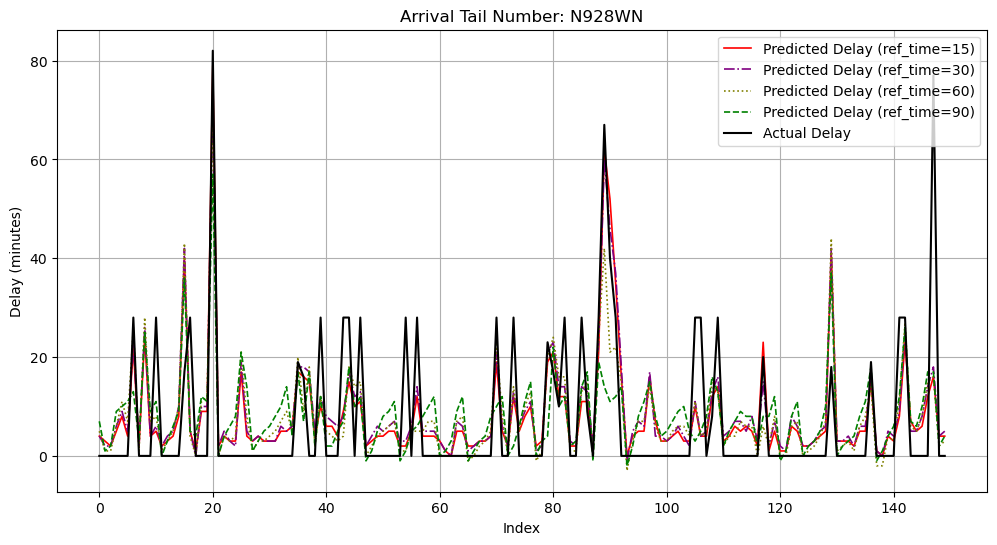

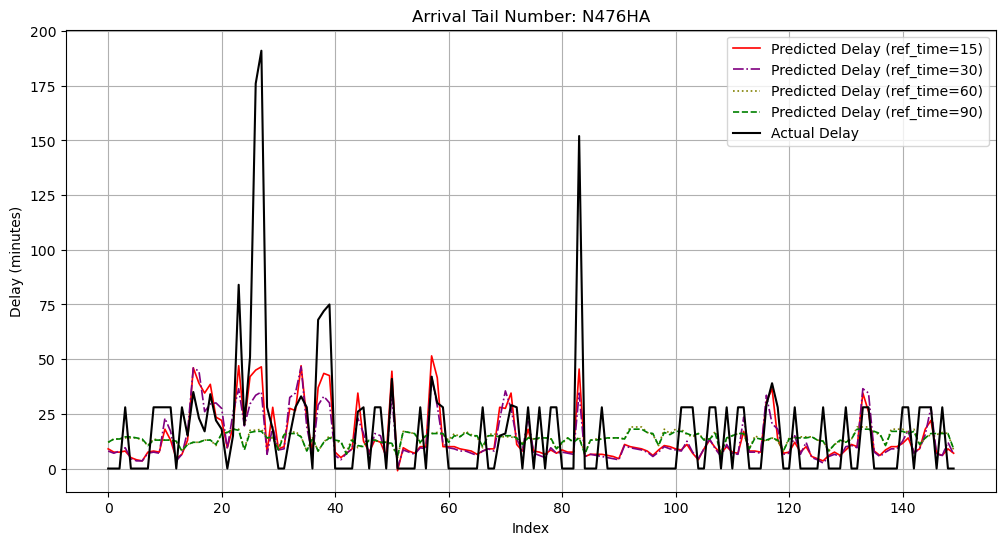

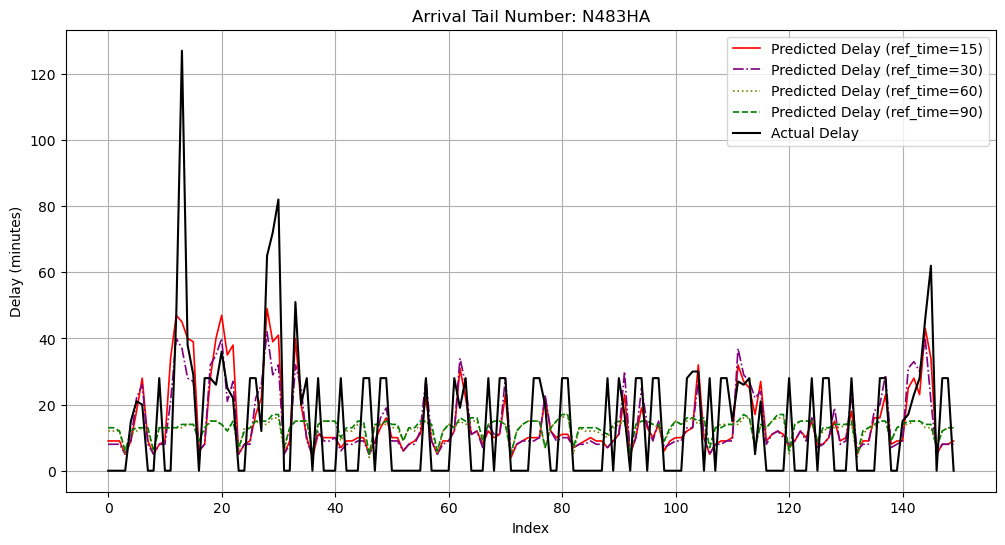

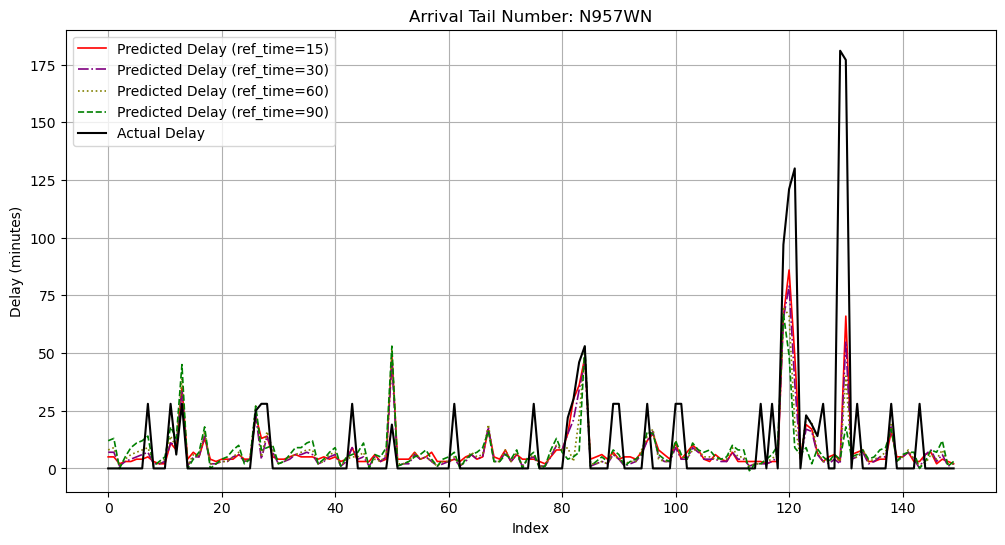

In [155]:
final_results_a2['CRSArrHour'] = final_results_a2['CRSArrTimestamp'].dt.hour
final_pred_agg_a2 = final_results_a2.groupby(['Tail_Number', 'FlightDate', 'CRSArrHour']).agg({'CLADelay': 'mean', 'Pred_ArrDelay15': 'mean', 'Pred_ArrDelay30': 'mean', 'Pred_ArrDelay60': 'mean', 'Pred_ArrDelay90': 'mean'}).reset_index()

tail_numbers = TN_count['Tail_Number'].unique().tolist()
print (tail_numbers)
for tn in tail_numbers:
    
    row = final_pred_agg_a2[final_pred_agg_a2['Tail_Number'] == tn].copy().reset_index()
    if (len(row))>0:
        row = row.sort_index()
        # row = row[row['CLADelay']>0]
        # airport = row['Dest'].unique()
        # print (airport)
        
        plt.figure(figsize=(12, 6))
    
        # Loop through different reference times with improved visual differentiation
        for ref_time, color, style in zip([15, 30, 60, 90], ['red', 'purple', 'olive', 'green'], ['-', '-.', ':', '--']):
            plt.plot(
                row[0:150].index, 
                row[0:150]['Pred_ArrDelay' + str(ref_time)], 
                label=f'Predicted Delay (ref_time={ref_time})', 
                linestyle=style, 
                color=color, 
                linewidth=1.2, 
                # alpha=0.8
            )
    
        # Plot the actual delay
        plt.plot(row[0:150].index, row[0:150]['CLADelay'], label='Actual Delay', color='black', linewidth=1.5)
    
        
        plt.title(f'Arrival Tail Number: {tn}')
        plt.xlabel('Index')
        plt.ylabel('Delay (minutes)')
        plt.legend()
        plt.grid(True)
        plt.show()